# Value at Risk

---

El **Valor en Riesgo** (Value at Risk o VaR) es una de las medidas de riesgo más utilizadas en finanzas. Particularmente, el VaR busca medir el riesgo de mercado en un portafolio.

Matemáticamente, esta medida es el cuantil de la distrubición de nuestra cantidad de interés (rendimientos de un portafolio, pérdida en una cartera de asegurados, etc.) y utiliza las observaciones pasadas con el fin de valorar las posibles pérdidas en el futuro.

Recordemos que un cuantil de nivel $\alpha$ de la distribución $F_{X}$, se define como el número $q_{\alpha}$ tal que

$$ F_{X}(q_{\alpha}) = \mathbb{P}[X \leq q_{\alpha}] = \alpha$$

El VaR se define como una medida de riesgo (estadística) que estima la máxima pérdida que puede presentar un portafolio dado un nivel de confianza $\alpha$.

Si la variable aleatoria $X$ representa los rendimientos de un portafolio, el VaR con un nivel de confianza $\alpha$, es el número $VaR_{X}(\alpha)$ tal que:

$$\mathbb{P}[X \leq VaR_{X}(\alpha)] \leq 1- \alpha$$

Por ejemplo si $\alpha = 0.95$, entonces el $VaR_{X}(0.95)$ se puede interpretar como el rendimiento que se tendría en menos del $5\%$ de los casos.

Podemos ver así, que el $VaR_{X}(\alpha)$ representa el cuantil $1 - \alpha$ de la distribución de $X$.

In [4]:
import numpy as np
import pandas as pd
from scipy.stats import norm


## VaR Paramétrico
---

Suponga que $X \sim N(\mu, \sigma)$ es una variable aleatoria que representa los rendimientos diarios de un portafolio.

Podemos calcular el $VaR_{X}(\alpha)$ de la siguiente manera:

$$
\begin{array}{ccl}
\mathbb{P}[X \leq VaR_{X}(\alpha)] & \leq & 1 - \alpha \\
\mathbb{P}\left[Z \leq \dfrac{VaR_{X}(\alpha) - \mu}{\sigma}\right] & = & 1 - \alpha \\
VaR_{X}(\alpha) & = & \mu + \sigma \Phi^{-1}(1 - \alpha) \\
 & = & \mu - \sigma \Phi^{-1}(\alpha) \\
\end{array}
$$

en donde $Z$ es una variable aleatoria normal, $\Phi^{-1}$ es la función inversa de la función de distribución de una variable aleatoria normal.

**Ejercicio**
Utilizando el desarrollo anterior, programe una función que estime el var paramétrico para un conjunto de observaciones.

**Sugerencia** 
Lea la documentación de 
```python
help(norm.ppf)
help(np.std)
```

In [3]:
#Escriba aquí su código

## VaR Histórico (no paramétrico)

A diferencia del VaR paramétrico, el VaR histórico no asume ninguna distribución para los rendimientos de un portafolio.

Su cálculo se realiza calculando los cuantiles empíricos de los datos dados.

**Ejercicio**  Lea la documentación de
```python
help(np.quantile)
```
y programe una función que calcule el VaR histórico.

**Sugerencia** Recuerde la definición de un cuantil $q_\alpha$ así como la interpretación del VaR.

In [ ]:
#Escriba su código aquí

## Conditional Value at Risk (CVaR)

CVaR is what many consider an improvement on VaR, as it takes into account the shape of the returns distribution. It is also known as Expected Shortfall (ES), as it is an expectation over all the different possible losses greater than VaR and their corresponding estimated likelihoods.

If you are not familiar with expectations, much content is available online. However we will provide a brief refresher.

### Expected Value

Say you have a fair six sided die. Each number is equally likely. The notion of an expectation, written as $\mathrm{E}(X)$, is what should you expect to happen out of all the possible outcomes. To get this you multiply each event by the probability of that event and add that up, think of it as a probability weighted average. With a die we get

$$1/6 \times 1 + 1/6 \times 2 + 1/6 \times 3 + 1/6 \times 4 + 1/6 \times 5 + 1/6 \times 6 =  3.5$$

When the probabilities are unequal it gets more complicated, and when the outcomes are continuous we have to use integration in closed form equations. Here is the formula for CVaR.

$$CVaR_{\alpha}(x) \approx \frac{1}{(1-\alpha)} \int_{f(x,y) \geq VaR_{\alpha}(x)} f(x,y)p(y)dy dx$$

In [19]:
def cvar(value_invested, returns, weights, alpha=0.95, lookback_days=520):
    # Call out to our existing function
    var = value_at_risk(value_invested, returns, weights, alpha, lookback_days=lookback_days)
    returns = returns.fillna(0.0)
    portfolio_returns = returns.iloc[-lookback_days:].dot(weights)
    
    # Get back to a return rather than an absolute loss
    var_pct_loss = var / value_invested
    
    return value_invested * np.nanmean(portfolio_returns[portfolio_returns < var_pct_loss])

Let's compute CVaR on our data and see how it compares with VaR.

In [20]:
cvar(value_invested, returns, weights, lookback_days=500)

-20763.593360233601

In [21]:
value_at_risk(value_invested, returns, weights, lookback_days=500)

-16025.325166269373

CVaR is higher because it is capturing more information about the shape of the distribution, AKA the moments of the distribution. If the tails have more mass, this will capture that. In general it is considered to be a far superior metric compared with VaR and you should use it over VaR in most cases.

Let's visualize what it's capturing.

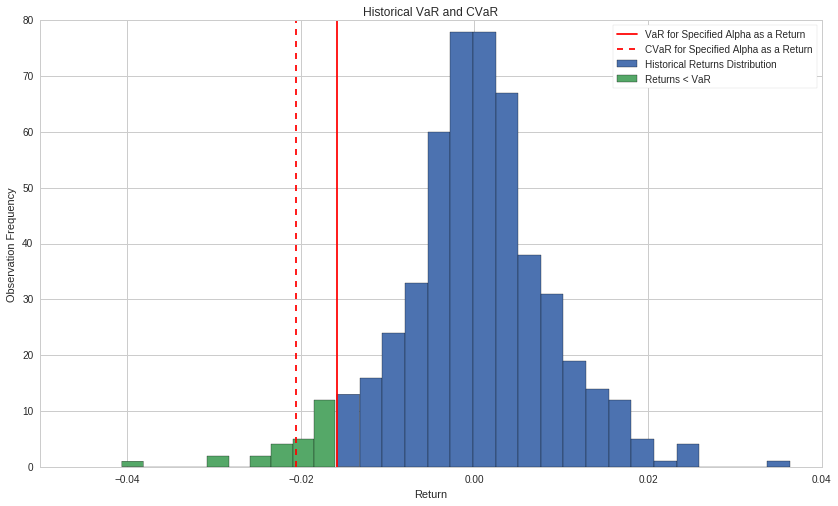

In [22]:
lookback_days = 520
alpha = 0.95

# Multiply asset returns by weights to get one weighted portfolio return
portfolio_returns = returns.fillna(0.0).iloc[-lookback_days:].dot(weights)

portfolio_VaR = value_at_risk(value_invested, returns, weights, alpha=0.95)
# Need to express it as a return rather than absolute loss
portfolio_VaR_return = portfolio_VaR / value_invested

portfolio_CVaR = cvar(value_invested, returns, weights, alpha=0.95)
# Need to express it as a return rather than absolute loss
portfolio_CVaR_return = portfolio_CVaR / value_invested

# Plot only the observations > VaR on the main histogram so the plot comes out
# nicely and doesn't overlap.
plt.hist(portfolio_returns[portfolio_returns > portfolio_VaR_return], bins=20)
plt.hist(portfolio_returns[portfolio_returns < portfolio_VaR_return], bins=10)
plt.axvline(portfolio_VaR_return, color='red', linestyle='solid');
plt.axvline(portfolio_CVaR_return, color='red', linestyle='dashed');
plt.legend(['VaR for Specified Alpha as a Return',
            'CVaR for Specified Alpha as a Return',
            'Historical Returns Distribution', 
            'Returns < VaR'])
plt.title('Historical VaR and CVaR');
plt.xlabel('Return');
plt.ylabel('Observation Frequency');

###Checking for Convergence Again

Finally, we'll check for convergence.

/usr/local/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


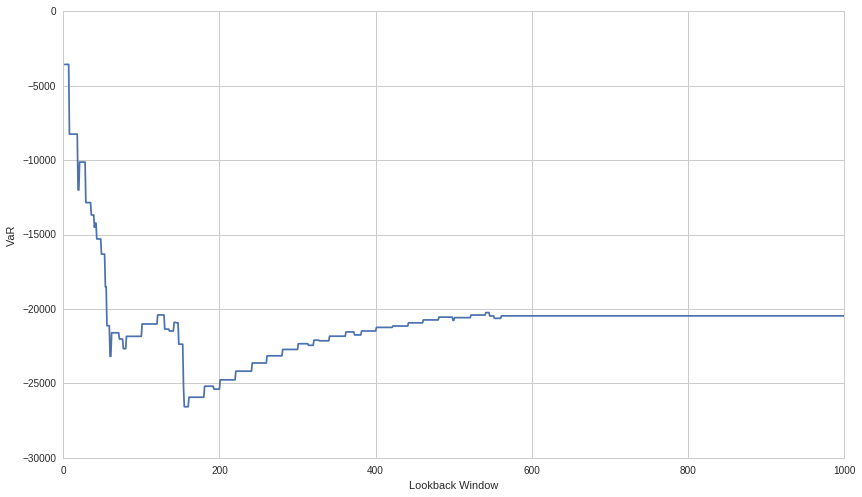

In [23]:
N = 1000
CVaRs = np.zeros((N, 1))
for i in range(N):
    CVaRs[i] = cvar(value_invested, returns, weights, lookback_days=i)

plt.plot(CVaRs)
plt.xlabel('Lookback Window')
plt.ylabel('VaR');

# Sources

 * http://www.wiley.com/WileyCDA/WileyTitle/productCd-1118445597.html
 * http://www.ise.ufl.edu/uryasev/publications/
 * http://www.ise.ufl.edu/uryasev/files/2011/11/VaR_vs_CVaR_CARISMA_conference_2010.pdf
 * http://faculty.washington.edu/ezivot/econ589/me20-1-4.pdf

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by Quantopian, Inc. ("Quantopian"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, Quantopian, Inc. has not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information, believed to be reliable, available to Quantopian, Inc. at the time of publication. Quantopian makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*